In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set()

In [7]:
fit = pd.read_csv('/data/log/logoften/rep00/fitnesslog.txt', delimiter="\t")
fit.head()

,gen,ind,rep,fake,fitness
0,0,0,0,1.108820,-4.98837
1,0,1,0,1.065790,-2381.09000
2,0,2,0,1.024070,-5.00000
3,0,3,0,0.619944,1734.92000
4,0,4,0,0.853555,-5.00000


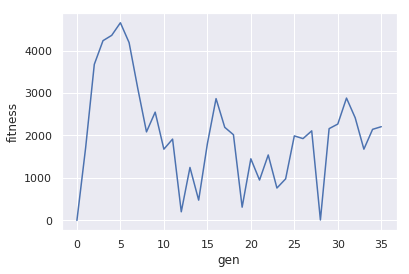

In [12]:
sns.lineplot(y='fitness', x='gen', data=fit, ci=None, estimator='median')